In [1]:
import tensorflow as tf
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time

In [2]:
from utils import *

# Data Loading

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
theta_0_range = np.arange(0.5, 1.75, 0.25)
omega_0_range = np.arange(0.5, 1.75, 0.25)
m_range = np.arange(1, 3, 0.5)
l_range = np.arange(1, 3, 0.5)
N_samples = 500
ti = 0.01
X = distribution_dataset_generator(theta_0_range, omega_0_range, m_range, l_range, 10, ti, N_samples)
Y = np.zeros(len(X))

In [5]:
X.shape

(400, 500)

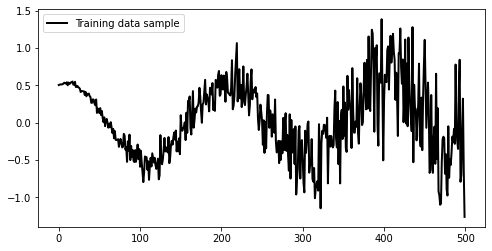

In [6]:
plt.figure(figsize = (8, 4))
plt.plot(X[0].T, label = 'Training data sample', color = 'black', lw=2)
plt.legend()
plt.show()

In [7]:
BATCH_SIZE = 25
train_set = tf.data.Dataset.from_tensor_slices(X).shuffle(X.shape[0]).batch(BATCH_SIZE)

# Generative Adversarial Network

In [8]:
noise_dim = 4
img_size = N_samples

In [9]:
def generator_model():
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(50, input_shape = (noise_dim,)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(100),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(250),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(img_size)
        ]
    )
    return model

In [10]:
def discriminator_model():
    model = tf.keras.Sequential(
        [
            tf.keras.layers.GaussianNoise(0.1, input_shape = (img_size, )),
            tf.keras.layers.Dense(250),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(100),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(50),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(1)
        ]
    )
    return model

# Training

In [11]:
EPOCHS = 500
N_CRITIC = 1
CLIP = 1e-3

In [12]:
# gen_optimizer = tf.keras.optimizers.Adam(1e-4)
# dis_optimizer = tf.keras.optimizers.Adam(1e-4)
gen_optimizer = tf.keras.optimizers.RMSprop(1e-3)
dis_optimizer = tf.keras.optimizers.RMSprop(1e-3)

In [13]:
discriminator = discriminator_model()
generator = generator_model()

In [14]:
def sample_from_generator(num_ex_to_gen = 16, noise_dim = noise_dim):
    seed = tf.random.uniform([num_ex_to_gen, noise_dim])
    predictions = generator(seed, training=False)
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.plot(predictions[i])
    plt.show()

In [15]:
@tf.function
def train_disc_step(images):

    noise = tf.random.uniform([BATCH_SIZE, noise_dim])
    # noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as disc_tape:

        generated_img = generator(noise, training=True)
        fake_output = discriminator(generated_img, training=True)
        true_output = discriminator(images, training=True)

        fake_loss, true_loss = tf.reduce_mean(fake_output), tf.reduce_mean(true_output)
        disc_loss = fake_loss - true_loss 
        
    grad_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    dis_optimizer.apply_gradients(zip(grad_discriminator, discriminator.trainable_variables))

    for w in discriminator.trainable_variables:
        w.assign(tf.clip_by_value(w, -CLIP, CLIP))

    return disc_loss, [true_loss, fake_loss]    

In [16]:
@tf.function
def train_gen_step():

    noise = tf.random.uniform([BATCH_SIZE, noise_dim])
    # noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape:

        generated_img = generator(noise, training=True)
        fake_output = discriminator(generated_img, training=True)
        gen_loss = - tf.reduce_mean(fake_output)

    grad_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gen_optimizer.apply_gradients(zip(grad_generator, generator.trainable_variables))

    return gen_loss

In [17]:
def train(dataset, epochs):
    gen_losses, disc_losses, true_losses, fake_losses = [], [], [], []

    for epoch in range(epochs):
        for img_batch in dataset:

            if img_batch.shape[0] != BATCH_SIZE:
                continue

            for i_c in range(N_CRITIC):
                disc_loss, [true_loss, fake_loss] = train_disc_step(img_batch)
            gen_loss = train_gen_step()
            
        if epoch % 10 == 0:
            print('Epoch', epoch, 'Gen loss', gen_loss, 'Disc loss', disc_loss)
            sample_from_generator() 

        gen_losses.append(gen_loss)
        disc_losses.append(disc_loss)
        true_losses.append(true_loss)
        fake_losses.append(fake_loss)
    
    print('Epoch', epoch, 'Gen loss', gen_loss, 'Disc loss', disc_loss)
    sample_from_generator()
    return gen_losses, disc_losses, true_losses, fake_losses

Epoch 0 Gen loss tf.Tensor(-2.1293797e-06, shape=(), dtype=float32) Disc loss tf.Tensor(7.254994e-07, shape=(), dtype=float32)


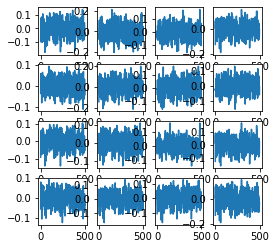

Epoch 10 Gen loss tf.Tensor(-1.2086943e-05, shape=(), dtype=float32) Disc loss tf.Tensor(-1.5931197e-05, shape=(), dtype=float32)


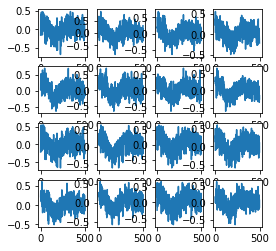

Epoch 20 Gen loss tf.Tensor(-3.350189e-08, shape=(), dtype=float32) Disc loss tf.Tensor(-8.346736e-07, shape=(), dtype=float32)


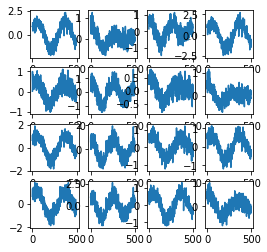

Epoch 30 Gen loss tf.Tensor(-5.6649988e-06, shape=(), dtype=float32) Disc loss tf.Tensor(-3.204706e-06, shape=(), dtype=float32)


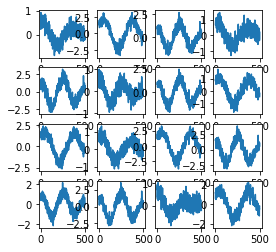

Epoch 40 Gen loss tf.Tensor(-5.7541893e-06, shape=(), dtype=float32) Disc loss tf.Tensor(-2.8104678e-06, shape=(), dtype=float32)


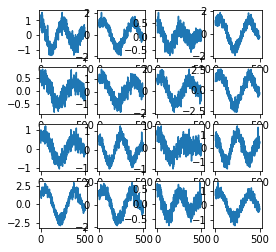

Epoch 50 Gen loss tf.Tensor(-4.3692694e-06, shape=(), dtype=float32) Disc loss tf.Tensor(-2.3014209e-06, shape=(), dtype=float32)


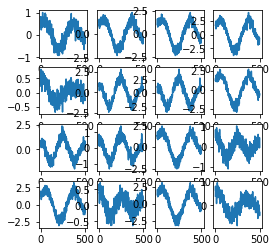

Epoch 60 Gen loss tf.Tensor(-4.5339907e-06, shape=(), dtype=float32) Disc loss tf.Tensor(-4.890473e-06, shape=(), dtype=float32)


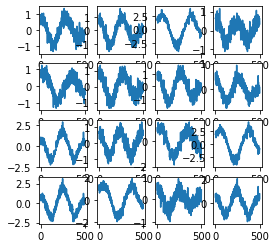

Epoch 70 Gen loss tf.Tensor(-3.1170919e-06, shape=(), dtype=float32) Disc loss tf.Tensor(-2.4738742e-06, shape=(), dtype=float32)


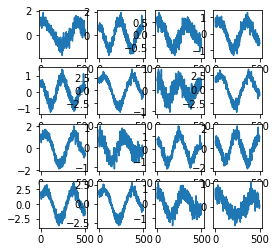

Epoch 80 Gen loss tf.Tensor(5.386218e-07, shape=(), dtype=float32) Disc loss tf.Tensor(1.8021883e-06, shape=(), dtype=float32)


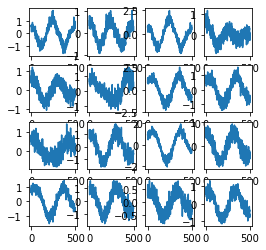

Epoch 90 Gen loss tf.Tensor(6.5890015e-07, shape=(), dtype=float32) Disc loss tf.Tensor(-3.1116676e-07, shape=(), dtype=float32)


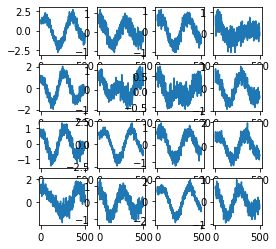

Epoch 100 Gen loss tf.Tensor(-2.2934375e-06, shape=(), dtype=float32) Disc loss tf.Tensor(-2.910565e-07, shape=(), dtype=float32)


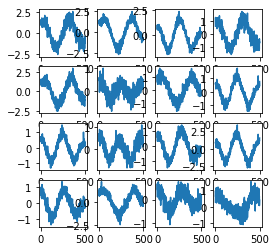

Epoch 110 Gen loss tf.Tensor(5.7234715e-06, shape=(), dtype=float32) Disc loss tf.Tensor(4.6020614e-07, shape=(), dtype=float32)


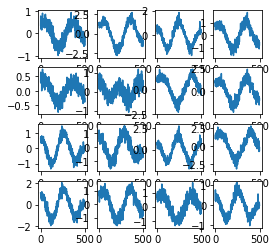

Epoch 120 Gen loss tf.Tensor(5.910672e-07, shape=(), dtype=float32) Disc loss tf.Tensor(-4.7236085e-07, shape=(), dtype=float32)


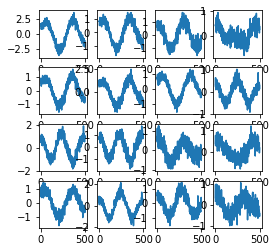

Epoch 130 Gen loss tf.Tensor(3.0976288e-08, shape=(), dtype=float32) Disc loss tf.Tensor(-9.944188e-10, shape=(), dtype=float32)


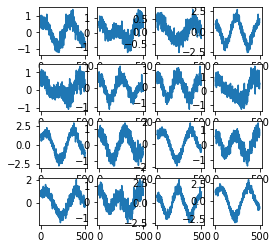

Epoch 140 Gen loss tf.Tensor(-1.737072e-06, shape=(), dtype=float32) Disc loss tf.Tensor(5.487991e-07, shape=(), dtype=float32)


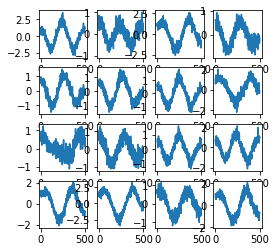

Epoch 150 Gen loss tf.Tensor(-3.6855677e-06, shape=(), dtype=float32) Disc loss tf.Tensor(-5.4270765e-07, shape=(), dtype=float32)


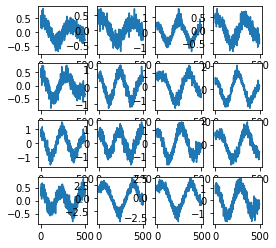

Epoch 160 Gen loss tf.Tensor(1.951725e-06, shape=(), dtype=float32) Disc loss tf.Tensor(2.4083988e-09, shape=(), dtype=float32)


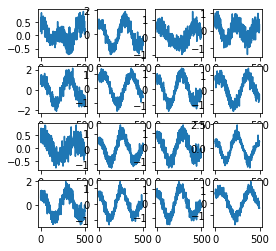

Epoch 170 Gen loss tf.Tensor(2.3160048e-07, shape=(), dtype=float32) Disc loss tf.Tensor(-6.4915116e-07, shape=(), dtype=float32)


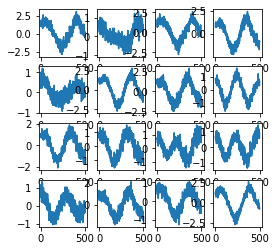

Epoch 180 Gen loss tf.Tensor(1.3840458e-06, shape=(), dtype=float32) Disc loss tf.Tensor(-7.867555e-07, shape=(), dtype=float32)


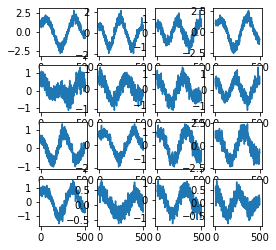

Epoch 190 Gen loss tf.Tensor(-5.4916313e-07, shape=(), dtype=float32) Disc loss tf.Tensor(3.176546e-07, shape=(), dtype=float32)


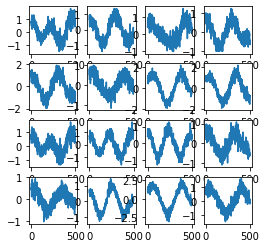

Epoch 200 Gen loss tf.Tensor(6.1657324e-06, shape=(), dtype=float32) Disc loss tf.Tensor(1.4655052e-07, shape=(), dtype=float32)


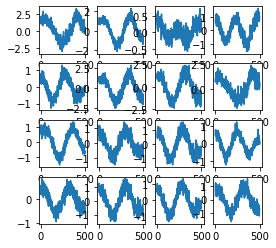

Epoch 210 Gen loss tf.Tensor(5.2145397e-06, shape=(), dtype=float32) Disc loss tf.Tensor(2.9734088e-07, shape=(), dtype=float32)


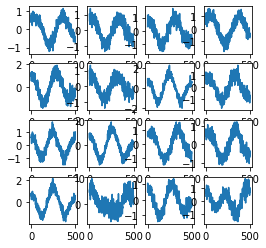

Epoch 220 Gen loss tf.Tensor(-4.5898305e-06, shape=(), dtype=float32) Disc loss tf.Tensor(-6.7948895e-07, shape=(), dtype=float32)


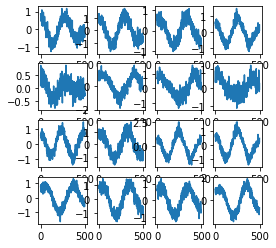

Epoch 230 Gen loss tf.Tensor(2.5410584e-06, shape=(), dtype=float32) Disc loss tf.Tensor(1.3573731e-07, shape=(), dtype=float32)


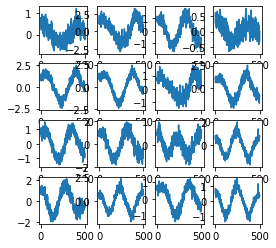

Epoch 240 Gen loss tf.Tensor(-3.6663196e-06, shape=(), dtype=float32) Disc loss tf.Tensor(-3.5495611e-07, shape=(), dtype=float32)


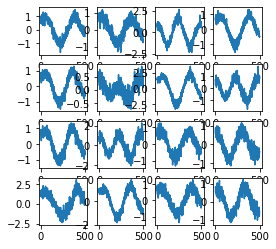

Epoch 250 Gen loss tf.Tensor(9.815842e-08, shape=(), dtype=float32) Disc loss tf.Tensor(3.6967754e-07, shape=(), dtype=float32)


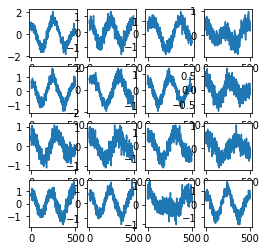

Epoch 260 Gen loss tf.Tensor(4.2148648e-07, shape=(), dtype=float32) Disc loss tf.Tensor(-8.1638103e-07, shape=(), dtype=float32)


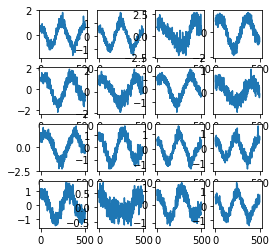

Epoch 270 Gen loss tf.Tensor(1.2022499e-06, shape=(), dtype=float32) Disc loss tf.Tensor(-1.8583046e-07, shape=(), dtype=float32)


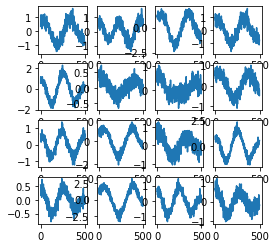

Epoch 280 Gen loss tf.Tensor(-3.7800378e-06, shape=(), dtype=float32) Disc loss tf.Tensor(2.3593611e-07, shape=(), dtype=float32)


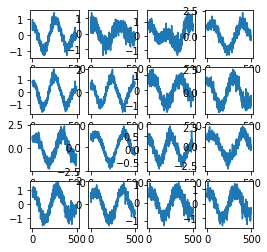

Epoch 290 Gen loss tf.Tensor(-3.5760132e-07, shape=(), dtype=float32) Disc loss tf.Tensor(7.2578257e-07, shape=(), dtype=float32)


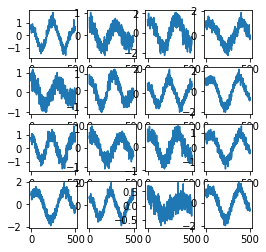

Epoch 300 Gen loss tf.Tensor(2.701687e-06, shape=(), dtype=float32) Disc loss tf.Tensor(1.3853958e-06, shape=(), dtype=float32)


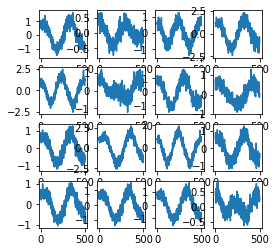

Epoch 310 Gen loss tf.Tensor(5.3041214e-07, shape=(), dtype=float32) Disc loss tf.Tensor(5.0942936e-07, shape=(), dtype=float32)


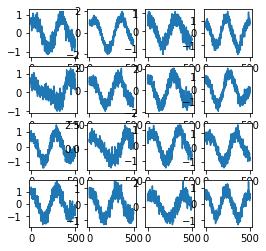

Epoch 320 Gen loss tf.Tensor(-1.4866308e-06, shape=(), dtype=float32) Disc loss tf.Tensor(-4.9477126e-07, shape=(), dtype=float32)


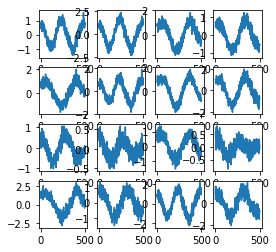

Epoch 330 Gen loss tf.Tensor(1.7508559e-06, shape=(), dtype=float32) Disc loss tf.Tensor(-1.7302727e-07, shape=(), dtype=float32)


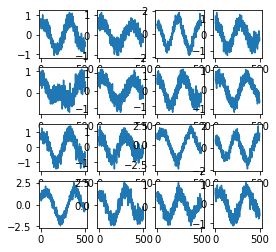

Epoch 340 Gen loss tf.Tensor(-6.7769133e-07, shape=(), dtype=float32) Disc loss tf.Tensor(3.71471e-07, shape=(), dtype=float32)


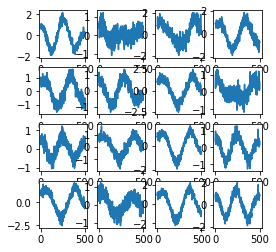

Epoch 350 Gen loss tf.Tensor(2.2040722e-06, shape=(), dtype=float32) Disc loss tf.Tensor(-7.0462875e-08, shape=(), dtype=float32)


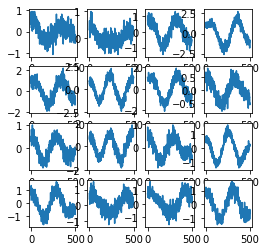

Epoch 360 Gen loss tf.Tensor(1.4903292e-06, shape=(), dtype=float32) Disc loss tf.Tensor(5.9296553e-07, shape=(), dtype=float32)


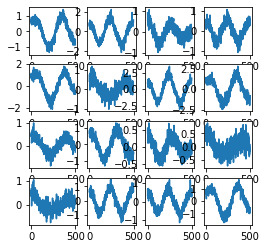

Epoch 370 Gen loss tf.Tensor(-5.072114e-06, shape=(), dtype=float32) Disc loss tf.Tensor(5.7501506e-07, shape=(), dtype=float32)


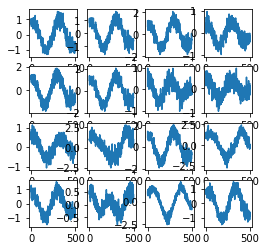

Epoch 380 Gen loss tf.Tensor(-4.403099e-06, shape=(), dtype=float32) Disc loss tf.Tensor(1.5455093e-06, shape=(), dtype=float32)


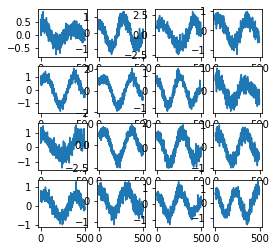

Epoch 390 Gen loss tf.Tensor(5.4133684e-06, shape=(), dtype=float32) Disc loss tf.Tensor(1.7689172e-07, shape=(), dtype=float32)


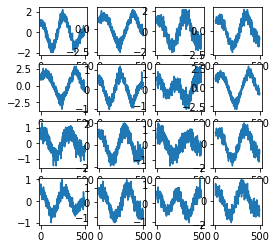

Epoch 400 Gen loss tf.Tensor(6.272081e-07, shape=(), dtype=float32) Disc loss tf.Tensor(3.0617207e-07, shape=(), dtype=float32)


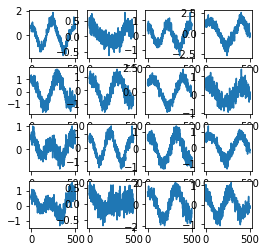

Epoch 410 Gen loss tf.Tensor(-2.9113448e-06, shape=(), dtype=float32) Disc loss tf.Tensor(-9.859415e-07, shape=(), dtype=float32)


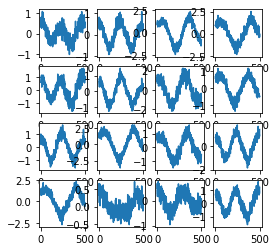

Epoch 420 Gen loss tf.Tensor(8.7651145e-08, shape=(), dtype=float32) Disc loss tf.Tensor(3.6989718e-07, shape=(), dtype=float32)


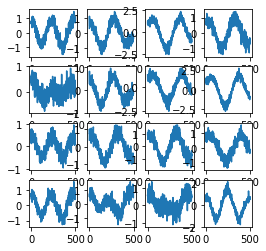

Epoch 430 Gen loss tf.Tensor(6.2343287e-07, shape=(), dtype=float32) Disc loss tf.Tensor(-2.5479937e-07, shape=(), dtype=float32)


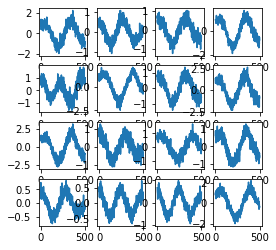

Epoch 440 Gen loss tf.Tensor(-3.917772e-06, shape=(), dtype=float32) Disc loss tf.Tensor(-1.2363263e-06, shape=(), dtype=float32)


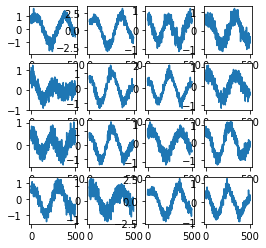

Epoch 450 Gen loss tf.Tensor(1.5119787e-06, shape=(), dtype=float32) Disc loss tf.Tensor(1.0611889e-06, shape=(), dtype=float32)


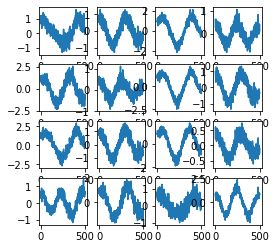

Epoch 460 Gen loss tf.Tensor(2.908282e-06, shape=(), dtype=float32) Disc loss tf.Tensor(-6.1861357e-07, shape=(), dtype=float32)


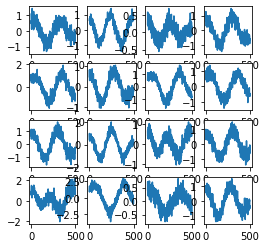

Epoch 470 Gen loss tf.Tensor(-1.7488503e-06, shape=(), dtype=float32) Disc loss tf.Tensor(1.0163441e-06, shape=(), dtype=float32)


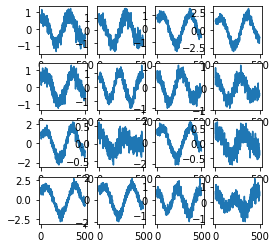

Epoch 480 Gen loss tf.Tensor(-3.3292433e-06, shape=(), dtype=float32) Disc loss tf.Tensor(2.609977e-07, shape=(), dtype=float32)


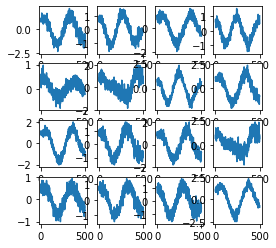

Epoch 490 Gen loss tf.Tensor(-3.1316772e-06, shape=(), dtype=float32) Disc loss tf.Tensor(4.6147818e-07, shape=(), dtype=float32)


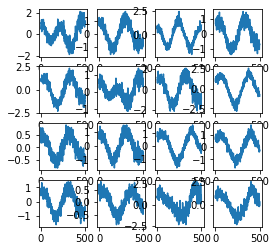

Epoch 499 Gen loss tf.Tensor(5.7086515e-07, shape=(), dtype=float32) Disc loss tf.Tensor(3.2615785e-07, shape=(), dtype=float32)


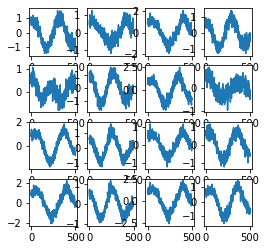

In [19]:
gen_losses, disc_losses, true_losses, fake_losses = train(train_set, EPOCHS)

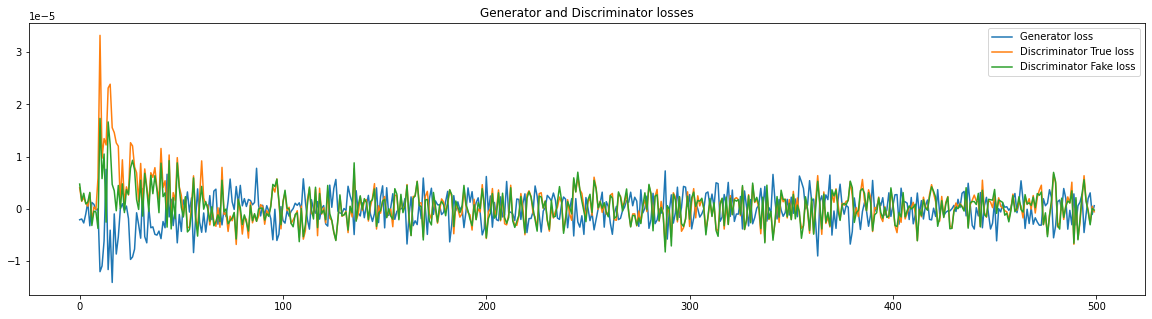

In [20]:
plt.figure(figsize=(20, 5))
plt.title('Generator and Discriminator losses')
plt.plot(gen_losses, label = 'Generator loss')
plt.plot(true_losses, label = 'Discriminator True loss')
plt.plot(fake_losses, label = 'Discriminator Fake loss')
plt.legend()
plt.show()

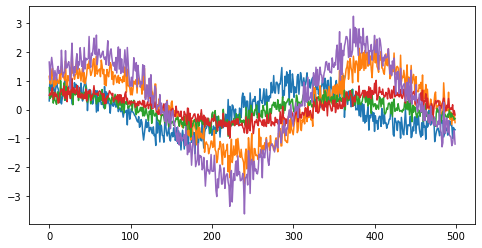

In [31]:
seed = tf.random.uniform([5, noise_dim])
predictions = generator(seed, training=False)

plt.figure(figsize = (8, 4))
plt.plot(predictions.numpy().T)
plt.show()